In [161]:
import squarify
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import copy
import heapq
import random
import cv2
from shapely.geometry import Polygon, LineString, Point

In [250]:
# Define room types and constraints
constraints = [
    {"type": "livingroom", "size": 8}, {"type": "bedroom", "size": 5},
    {"type": "bedroom", "size": 5}, {"type": "kitchen", "size": 4},
    {"type": "toilet", "size": 3}, {"type": "attachedbathroom", "size": 3},
    {"type": "laundryroom", "size": 2}, {"type": "library", "size": 4},
    {"type": "masterbedroom", "size": 6}, {"type": "bedroom", "size": 4}
]

# constraints = [
#     {"type": "bedroom", "size": 5},{"type": "livingroom", "size": 9},
#     {"type": "bedroom", "size": 5}, {"type": "kitchen", "size": 4}, {"type": "attachedbathroom", "size": 3},
#     {"type": "laundryroom", "size": 2}, {"type": "library", "size": 4},
#     {"type": "masterbedroom", "size": 6}
# ]

# Area type mapping
area_types = {
    'livingroom': 'social', 'diningroom': 'social', 'library': 'private',
    'bedroom': 'private', 'guestroom': 'service', 'masterbedroom': 'private',
    'attachedbathroom': 'private', 'kitchen': 'service', 'laundryroom': 'service',
    'toilet': 'social', 'pantry': 'service'
}

In [300]:
def group_rooms(constraints, area_types):
    grouped_rooms = {"social": [], "service": [], "private": []}
    room_counters = {}  # Keeps track of room counts to generate unique names

    for room in constraints:
        room_type = room["type"]
        area_type = area_types.get(room_type, None)
        
        if area_type:
            # Increment counter for this room type
            room_counters[room_type] = room_counters.get(room_type, 0) + 1
            unique_name = f"{room_type}_{room_counters[room_type]}"  # Append count

            # Add room with unique name
            grouped_rooms[area_type].append({"name": unique_name, "size": room["size"]})

    return grouped_rooms

def squarify_areas(grouped_rooms):
    area_sizes = {area: sum(r["size"] for r in rooms) for area, rooms in grouped_rooms.items()}
    norm_area_sizes = squarify.normalize_sizes(list(area_sizes.values()), 100, 100)
    areas = squarify.squarify(norm_area_sizes, x=0, y=0, dx=100, dy=100)
    return areas

def allocate_rooms(rooms, area):
    room_sizes = [r["size"] for r in rooms]
    #room_labels = [r["type"] for r in rooms]
    room_labels = [r["name"] for r in rooms]
    norm_sizes = squarify.normalize_sizes(room_sizes, area["dx"], area["dy"])
    return squarify.squarify(norm_sizes, x=area["x"], y=area["y"], dx=area["dx"], dy=area["dy"]), room_labels


# Function to check if two rooms share an edge
def share_edge(rect1, rect2, door_length=2, tol=1e-5):
    x1, y1, w1, h1 = rect1["x"], rect1["y"], rect1["dx"], rect1["dy"]
    x2, y2, w2, h2 = rect2["x"], rect2["y"], rect2["dx"], rect2["dy"]

    # Check vertical adjacency
    vertical_overlap = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
    vertical_touch = (abs(x1 - (x2 + w2)) < tol or abs(x2 - (x1 + w1)) < tol) and vertical_overlap >= door_length

    # Check horizontal adjacency
    horizontal_overlap = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
    horizontal_touch = (abs(y1 - (y2 + h2)) < tol or abs(y2 - (y1 + h1)) < tol) and horizontal_overlap >= door_length

    return vertical_touch or horizontal_touch

def build_graph(room_data):
    # Create an undirected graph
    graph = nx.Graph()

    # Add nodes with labels
    for i, data in room_data.items():
        graph.add_node(i, label=data["label"])

    # Add edges based on shared edges
    for i, data1 in room_data.items():
        for j, data2 in room_data.items():
            if i < j and share_edge(data1["rect"], data2["rect"]):  
                graph.add_edge(i, j)

    return graph

def get_room_data_and_graph(grouped_rooms, squarified_areas):
    room_data = {}  # Dictionary to store room data
    room_id = 0  # Unique identifier for each room

    for (area, area_rect) in zip(grouped_rooms.keys(), squarified_areas):
        rects, labels = allocate_rooms(grouped_rooms[area], area_rect)
        
        # Store each room's data in the dictionary
        for rect, label in zip(rects, labels):
            room_data[room_id] = {"label": label, "rect": rect}
            room_id += 1
    # Add adjacency information to room_data
    for i in room_data:
        room_data[i]["adjacent_rooms"] = [
            j for j in room_data if i != j and share_edge(room_data[i]["rect"], room_data[j]["rect"])
        ]
    graph = build_graph(room_data)

    return room_data, graph


def plot_treemap(room_data):
    # Plot the treemap using room_data
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.set_facecolor("gray")

    for i, data in room_data.items():
        rect = data["rect"]
        x, y, w, h = rect["x"], rect["y"], rect["dx"], rect["dy"]
        ax.add_patch(plt.Rectangle((x, y), w, h, facecolor="gray", edgecolor="black", linewidth=5))
        ax.text(x + w / 2, y + h / 2, data["label"], ha="center", va="center", fontsize=10, color="black")

    plt.show()

def plot_graph(graph, room_data):
    # Plot the adjacency graph
    plt.figure(figsize=(8, 8))
    pos = {i: (room_data[i]["rect"]["x"] + room_data[i]["rect"]["dx"] / 2, 
            room_data[i]["rect"]["y"] + room_data[i]["rect"]["dy"] / 2) 
        for i in graph.nodes}

    nx.draw(graph, pos, labels={i: room_data[i]["label"] for i in graph.nodes}, with_labels=True, node_size=3000, node_color="lightblue")
    plt.show()

def get_swappable_rooms(room_data):
    # Define a tolerance value
    TOLERANCE = 1e-3  

    # Identify swappable room pairs
    swappable_rooms = []
    for i, room1 in room_data.items():
        for j in room1['adjacent_rooms']:
            if i >= j:  # Avoid duplicate pairs
                continue

            room2 = room_data[j]
            
            # Ensure same area type
            if area_types[room1['label']] == area_types[room2['label']]:
                rect1, rect2 = room1['rect'], room2['rect']
                
                # Check if they have approximately the same x-coordinates or y-coordinates
                same_x = math.isclose(rect1['x'], rect2['x'], abs_tol=TOLERANCE) and \
                        math.isclose(rect1['dx'], rect2['dx'], abs_tol=TOLERANCE)
                same_y = math.isclose(rect1['y'], rect2['y'], abs_tol=TOLERANCE) and \
                        math.isclose(rect1['dy'], rect2['dy'], abs_tol=TOLERANCE)
                
                if same_x or same_y:
                    swappable_rooms.append((i, j))
    return swappable_rooms

def swap_rooms(room_data, pair):
    """Swaps the positions of two rooms while keeping their dimensions unchanged."""
    i, j = pair
    TOLERANCE = 1e-3  
    # Create a deep copy to avoid modifying the original data
    swapped_room_data = copy.deepcopy(room_data)

    # Get the original positions
    rect1, rect2 = swapped_room_data[i]["rect"], swapped_room_data[j]["rect"]

    # When a change in y coordinate is needed
    if math.isclose(rect1['x'], rect2['x'], abs_tol=TOLERANCE) and math.isclose(rect1['dx'], rect2['dx'], abs_tol=TOLERANCE):
        print("y coordinate change is needed.")
        if rect1["y"] > rect2["y"]:
            # assign new position to rect1
            rect1["y"] = rect2["y"]
            # assign new position to rect2
            rect2["y"] = rect1["y"] + rect1["dy"]
            
        elif rect2["y"] > rect1["y"]:
            # assign new position to rect2
            rect2["y"] = rect1["y"]
            # assign new position to rect1
            rect1["y"] = rect2["y"] + rect2["dy"]

    # When a change in x coordinate is needed
    if math.isclose(rect1['y'], rect2['y'], abs_tol=TOLERANCE) and math.isclose(rect1['dy'], rect2['dy'], abs_tol=TOLERANCE):
        print("x coordinate change is needed.")
        if rect1["x"] > rect2["x"]:
            # assign new position to rect1
            rect1["x"] = rect2["x"]
            # assign new position to rect2
            rect2["x"] = rect1["x"] + rect1["dx"]
            
        elif rect2["x"] > rect1["x"]:
            # assign new position to rect2
            rect2["x"] = rect1["x"]
            # assign new position to rect1
            rect1["x"] = rect2["x"] + rect2["dx"]

    updated_graph = build_graph(swapped_room_data)
    return swapped_room_data, updated_graph  # Return the modified copy


def plot_graph_and_contour(graph_data, path, padding=5):
    vertices = graph_data["vertices"]
    edges = graph_data["edges"]

    # Determine min and max coordinates
    all_x = [v[0] for v in vertices]
    all_y = [v[1] for v in vertices]

    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)

    # Apply padding
    min_x -= padding
    max_x += padding
    min_y -= padding
    max_y += padding

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.set_facecolor("white")

    # Plot original graph (black edges)
    for (v1, v2) in edges:
        x_values = [v1[0], v2[0]]
        y_values = [v1[1], v2[1]]
        ax.plot(x_values, y_values, "k-", linewidth=5)  # Light black edges

    # Plot vertices (red dots)
    for vertex in vertices:
        ax.plot(vertex[0], vertex[1], "ro", markersize=4)

    for (v1, v2) in path:
        x_values = [v1[0], v2[0]]
        y_values = [v1[1], v2[1]]
        ax.plot(x_values, y_values, "g-", linewidth=5)
    plt.show()



def euclidean_distance(v1, v2):
    return math.sqrt((v1[0] - v2[0]) ** 2 + (v1[1] - v2[1]) ** 2)

def shortest_path_to_connect_rooms(graph_data, entry_point, disconnected_rooms):
    vertices = graph_data['vertices']
    edges = graph_data['edges']

    # Priority queue for BFS-like search: (cost, current_vertex, path_edges, covered_rooms)
    pq = [(0, entry_point, [], set())]  
    visited = {}

    while pq:
        cost, current_vertex, path_edges, covered_rooms = heapq.heappop(pq)

        # If all disconnected rooms are covered, return the path
        if covered_rooms >= set(disconnected_rooms):
            return path_edges

        # If we reach a vertex with a better room coverage, update visited
        state = (current_vertex, frozenset(covered_rooms))
        if state in visited and visited[state] <= cost:
            continue
        visited[state] = cost

        # Explore neighbors
        for (v1, v2), edge_rooms in edges.items():
            if v1 == current_vertex or v2 == current_vertex:
                next_vertex = v2 if v1 == current_vertex else v1
                # new_cost = cost + 1  # Uniform edge weight
                new_cost = cost + euclidean_distance(current_vertex, next_vertex)
                new_path_edges = path_edges + [((v1, v2), edge_rooms)]
                
                # Track covered rooms
                new_covered_rooms = covered_rooms | set(edge_rooms)

                heapq.heappush(pq, (new_cost, next_vertex, new_path_edges, new_covered_rooms))

    return None  # No path found

def remove_outside_edges_and_corners(graph_data, grid_size=100):
    edges = graph_data["edges"].copy()  # Copy to avoid modifying original data
    vertices = graph_data["vertices"].copy()  # Copy to avoid modifying original data

    # Identify boundary edges
    boundary_edges = set()
    for (v1, v2) in graph_data["edges"].keys():
        if (0 in v1 or grid_size in v1) and (0 in v2 or grid_size in v2):
            boundary_edges.add((v1, v2))

    # Remove the boundary edges from the global edges dictionary
    for edge in boundary_edges:
        if edge in edges:
            del edges[edge]

    # Define corner vertices
    corner_vertices = {(0, 0), (grid_size, 0), (0, grid_size), (grid_size, grid_size)}

    # Remove corner vertices if they are present
    for corner in corner_vertices:
        if corner in vertices:
            del vertices[corner]

    return {
        "vertices": vertices,
        "edges": edges,
        "room_vertices": graph_data["room_vertices"],  # Keeping original room vertices
    }

def plot_treemap_absolute(room_data):
    # Plot the treemap using updated absolute coordinates
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.set_facecolor("gray")

    for i, data in room_data.items():
        rect = data["rect"]
        x1, y1, x2, y2 = rect["x1"], rect["y1"], rect["x2"], rect["y2"]
        width = x2 - x1
        height = y2 - y1

        ax.add_patch(plt.Rectangle((x1, y1), width, height, facecolor="gray", edgecolor="black", linewidth=4))
        ax.text(x1 + width / 2, y1 + height / 2, data["label"], ha="center", va="center", fontsize=10, color="black")

    plt.show()

def convert_to_absolute(room_data):
    new_room_data = {}
    for room_id, room in room_data.items():
        x = room['rect']['x']
        y = room['rect']['y']
        dx = x + room['rect']['dx']  # Convert width to absolute x2
        dy = y + room['rect']['dy']  # Convert height to absolute y2
        
        new_room_data[room_id] = {
            'label': room['label'],
            'rect': {'x1': x, 'y1': y, 'x2': dx, 'y2': dy},
            'adjacent_rooms': room['adjacent_rooms']
        }
    
    return new_room_data

def convert_to_graph_with_room_info(room_data):
    def round_vertex(v, precision=6):
        """Round a vertex to avoid floating-point precision errors."""
        return (round(v[0], precision), round(v[1], precision))

    vertices = {}  # {(x, y): [room_labels]}
    edges = {}  # {(v1, v2): [room_labels]}
    room_vertices = {}  # {room_label: [(x, y)]}

    # Step 1: Collect all room vertices first
    for room_id, room in room_data.items():
        room_label = room["label"]
        rect = room["rect"]
        x1, y1, x2, y2 = rect["x1"], rect["y1"], rect["x2"], rect["y2"]

        # Define four corners with rounding
        top_left = round_vertex((x1, y1))
        top_right = round_vertex((x2, y1))
        bottom_left = round_vertex((x1, y2))
        bottom_right = round_vertex((x2, y2))

        # Store room vertices
        room_vertices[room_label] = [top_left, top_right, bottom_left, bottom_right]

        # Add vertices to global dictionary
        for vertex in [top_left, top_right, bottom_left, bottom_right]:
            if vertex not in vertices:
                vertices[vertex] = []
            if room_label not in vertices[vertex]:  # Avoid duplicate labels
                vertices[vertex].append(room_label)

    # Step 2: Add edges with segmentation logic
    def get_intermediate_vertices(v1, v2):
        """Find all vertices that lie on the line segment between v1 and v2."""
        x1, y1 = v1
        x2, y2 = v2
        intermediate = []

        for v in vertices.keys():
            if v == v1 or v == v2:
                continue
            x, y = v

            # Check if the vertex is collinear and lies within the segment bounds
            if (x1 == x2 and x1 == x and min(y1, y2) < y < max(y1, y2)) or \
               (y1 == y2 and y1 == y and min(x1, x2) < x < max(x1, x2)):
                intermediate.append(v)

        return sorted(intermediate, key=lambda p: (p[0], p[1]))  # Sort for correct traversal

    for room_label, room_verts in room_vertices.items():
        edges_to_add = [
            (room_verts[0], room_verts[1]),  # Top edge
            (room_verts[1], room_verts[3]),  # Right edge
            (room_verts[2], room_verts[3]),  # Bottom edge
            (room_verts[0], room_verts[2]),  # Left edge
        ]

        for v1, v2 in edges_to_add:
            v1 = round_vertex(v1)
            v2 = round_vertex(v2)

            if v1 == v2:  # Prevent self-loops
                continue

            # Get any intermediate vertices between v1 and v2
            intermediate = get_intermediate_vertices(v1, v2)

            # If there are intermediate vertices, split the edge
            if intermediate:
                current = v1
                for mid in intermediate:
                    mid = round_vertex(mid)
                    edge = tuple(sorted((current, mid)))
                    if edge not in edges:
                        edges[edge] = []
                    edges[edge].append(room_label)
                    current = mid  

                edge = tuple(sorted((current, v2)))
                if edge not in edges:
                    edges[edge] = []
                edges[edge].append(room_label)
            else:
                edge = tuple(sorted((v1, v2)))
                if edge not in edges:
                    edges[edge] = []
                edges[edge].append(room_label)

    return {
        "vertices": vertices,
        "edges": edges,
        "room_vertices": room_vertices,
    }

def plot_graph_new(graph_data, padding=5):
    vertices = graph_data["vertices"]
    edges = graph_data["edges"]

    # Determine min and max coordinates
    all_x = [v[0] for v in vertices]
    all_y = [v[1] for v in vertices]

    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)

    # Apply padding
    min_x -= padding
    max_x += padding
    min_y -= padding
    max_y += padding

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.set_facecolor("white")

    # Plot edges
    for (v1, v2) in edges:
        x_values = [v1[0], v2[0]]
        y_values = [v1[1], v2[1]]
        ax.plot(x_values, y_values, "k-", linewidth=1)  # Black edges

    # Plot vertices
    for vertex in vertices:
        ax.plot(vertex[0], vertex[1], "ro", markersize=4)  # Red dots for vertices

    plt.show()

def plot_graph_edges(edges_dict, padding=5):
    """Plots edges from an edge dictionary using Matplotlib."""
    
    # Extract unique vertices from edges
    vertices = set()
    for edge in edges_dict.keys():
        vertices.update(edge)

    # Determine min and max coordinates
    all_x = [v[0] for v in vertices]
    all_y = [v[1] for v in vertices]

    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)

    # Apply padding
    min_x -= padding
    max_x += padding
    min_y -= padding
    max_y += padding

    # Create plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.set_facecolor("white")

    # Plot edges
    for (v1, v2) in edges_dict.keys():
        x_values = [v1[0], v2[0]]
        y_values = [v1[1], v2[1]]
        ax.plot(x_values, y_values, "k-", linewidth=4)  # Black edges
    plt.show()


def plot_graph_edges_with_doors(edges_dict, door_edges, padding=5):
    """Plots edges from an edge dictionary and overlays doors in white with a thin black outline."""
    
    # Extract unique vertices from edges
    vertices = set()
    for edge in edges_dict.keys():
        vertices.update(edge)

    # Determine min and max coordinates
    all_x = [v[0] for v in vertices]
    all_y = [v[1] for v in vertices]

    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)

    # Apply padding
    min_x -= padding
    max_x += padding
    min_y -= padding
    max_y += padding

    # Create plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.set_facecolor("white")

    # Plot original edges in black
    for (v1, v2) in edges_dict.keys():
        x_values = [v1[0], v2[0]]
        y_values = [v1[1], v2[1]]
        ax.plot(x_values, y_values, "k-", linewidth=4)  # Black walls

    # Plot door edges in white with a black outline using patheffects
    for (v1, v2) in door_edges.keys():
        x_values = [v1[0], v2[0]]
        y_values = [v1[1], v2[1]]
        ax.plot(x_values, y_values, "w-", linewidth=3)[0]  # White door

    plt.show()


def remove_room(graph_data, room_name):
    # Create a copy of the graph data to avoid modifying the original
    new_graph_data = {
        'vertices': graph_data['vertices'].copy(),
        'edges': graph_data['edges'].copy(),
        'room_vertices': graph_data['room_vertices'].copy()
    }

    # Identify edges that contain the room
    edges_to_remove = {edge for edge, rooms in graph_data['edges'].items() if room_name in rooms}


    # List of vertices affected
    vertices_connecting_to_deleted_room = []

    # Remove identified edges and collect affected vertices
    for edge in edges_to_remove:
        v1, v2 = edge
        print("removed edge:", new_graph_data['edges'][edge])

        # Check all vertices to see if they lie on this edge
        for vertex, rooms in graph_data['vertices'].items():
            if vertex in {v1, v2} and (vertex,rooms) not in vertices_connecting_to_deleted_room:
                for _edge, _rooms in graph_data['edges'].items():
                    if vertex in _edge and _edge != edge:
                        #print(f"The vertex {vertex} is in another edge: {_edge} of rooms {_rooms}.")
                        vertices_connecting_to_deleted_room.append((vertex, rooms))  # Store (vertex, room labels)
                        break
                

        del new_graph_data['edges'][edge]  # Remove edge
    

    for vertex, rooms in graph_data['vertices'].items():
        if room_name in rooms and (vertex, rooms) not in vertices_connecting_to_deleted_room:
            del new_graph_data['vertices'][vertex]
    
    return new_graph_data, vertices_connecting_to_deleted_room

def remove_redundant_edges(path):
    unique_edges = []
    seen_edges = set()

    for edge in path:
        edge_tuple = (edge[0][0], edge[0][1])  # ((x1, y1), (x2, y2))
        reverse_edge_tuple = (edge[0][1], edge[0][0])  # Consider undirected nature

        if edge_tuple not in seen_edges and reverse_edge_tuple not in seen_edges:
            unique_edges.append(edge)
            seen_edges.add(edge_tuple)
            seen_edges.add(reverse_edge_tuple)  # Add both directions to avoid revisiting

    return unique_edges

def plot_graph_with_path(graph_data, path, corridor_width = 35, padding=5):
    vertices = graph_data["vertices"]
    edges = graph_data["edges"]

    # Determine min and max coordinates
    all_x = [v[0] for v in vertices]
    all_y = [v[1] for v in vertices]

    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)

    # Apply padding
    min_x -= padding
    max_x += padding
    min_y -= padding
    max_y += padding

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.set_facecolor("white")

    # Plot original graph (black edges)
    for (v1, v2) in edges:
        x_values = [v1[0], v2[0]]
        y_values = [v1[1], v2[1]]
        ax.plot(x_values, y_values, "k-", linewidth=5)  # Light black edges

    # Plot vertices (red dots)
    for vertex in vertices:
        ax.plot(vertex[0], vertex[1], "ro", markersize=4)

    for (v1, v2), _ in path:
        x_values = [v1[0], v2[0]]
        y_values = [v1[1], v2[1]]
        ax.plot(x_values, y_values, color="#00FF00", linewidth=corridor_width) 
    
    # Save the figure
    plt.gca().set_position([0, 0, 1, 1])  # Remove padding
    plt.savefig("corridor.png", format="png", dpi=300, bbox_inches="tight", pad_inches=0)
    plt.show()

def get_color_boundary_edges(image_path = "corridor.png"):
    # Load the image
    image = cv2.imread(image_path)

    # Convert to RGB (OpenCV loads images in BGR format by default)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Define exact green color in RGB
    target_color = np.array([0, 255, 0])  # Pure green

    # Create a mask for the exact green color
    mask = np.all(image_rgb == target_color, axis=-1).astype(np.uint8) * 255  # Convert to binary mask

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank image to visualize the edges
    output = np.zeros_like(image)

    # List to store boundary edges (pairs of points)
    boundary_edges = []

    # Process each contour
    for contour in contours:
        # Approximate the contour to reduce points
        epsilon = 0.001 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Convert contour points to (x, y) format and store edges
        num_points = len(approx)
        for i in range(num_points):
            v1 = tuple(approx[i][0])  # Current vertex
            v2 = tuple(approx[(i + 1) % num_points][0])  # Next vertex (wrap around to the first)

            boundary_edges.append((v1, v2))  # Store as an edge (vertex pair)

        # Draw the approximated shape
        cv2.drawContours(output, [approx], -1, (0, 255, 0), 2)

    # Display the result
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.title("Detected Boundary Edges")
    plt.show()

    # Print boundary edges
    print("Detected Boundary Edges (as edges):", boundary_edges)

    return boundary_edges

def resize_graph_edges(original_graph_edges, original_size = 2400, new_size = 100):
    # Normalize edges with Y-axis flipping
    resized_graph_edges = [
        (
            (x1 / original_size * new_size, (1 - y1 / original_size) * new_size),  # Normalize and flip Y
            (x2 / original_size * new_size, (1 - y2 / original_size) * new_size)   # Normalize and flip Y
        )
        for (x1, y1), (x2, y2) in original_graph_edges
    ]

    # Print normalized edges
    print("Normalized Boundary Edges (100x100 scale):", )
    return resized_graph_edges

def merge_close_values_in_graph(edges, threshold=0.1):
    """Merge x-coordinates only with other x-coordinates and y-coordinates only with other y-coordinates."""
    
    # Collect all unique x and y values separately
    unique_x_values = set()
    unique_y_values = set()
    
    for (x1, y1), (x2, y2) in edges:
        unique_x_values.add(x1)
        unique_x_values.add(x2)
        unique_y_values.add(y1)
        unique_y_values.add(y2)

    # Sort x and y values separately
    sorted_x_values = sorted(unique_x_values)
    sorted_y_values = sorted(unique_y_values)

    # Merge close x values
    merged_x_values = {}
    merged_x_list = []

    for x in sorted_x_values:
        if merged_x_list and abs(merged_x_list[-1] - x) < threshold:
            merged_x_values[x] = merged_x_list[-1]  # Map close x values to previous value
        else:
            merged_x_list.append(x)
            merged_x_values[x] = x  # Keep the same value

    # Merge close y values
    merged_y_values = {}
    merged_y_list = []

    for y in sorted_y_values:
        if merged_y_list and abs(merged_y_list[-1] - y) < threshold:
            merged_y_values[y] = merged_y_list[-1]  # Map close y values to previous value
        else:
            merged_y_list.append(y)
            merged_y_values[y] = y  # Keep the same value

    # Replace values in edges with merged values
    new_edges = []
    for (x1, y1), (x2, y2) in edges:
        new_x1, new_y1 = merged_x_values[x1], merged_y_values[y1]
        new_x2, new_y2 = merged_x_values[x2], merged_y_values[y2]
        if new_x1 == 0:
            new_x1 = -0.1
        if new_x1 == 100:
            new_x1 = 100.1
        if new_y1 == 0:
            new_y1 = -0.1
        if new_y1 == 100:
            new_y1 = 100.1
        if new_x2 == 0:
            new_x2 = -0.1
        if new_x2 == 100:
            new_x2 = 100.1
        if new_y2 == 0:
            new_y2 = -0.1
        if new_y2 == 100:
            new_y2 = 100.1
                
        
        new_edges.append(((new_x1, new_y1), (new_x2, new_y2)))

    return new_edges

def format_corridor_edges(corridor_edges):
    """Convert corridor edges into graph format with 'corridor' label."""
    formatted_edges = {edge: ['corridor'] for edge in corridor_edges}
    return formatted_edges

def split_edges_at_intersections(edges_dict):
    """Splits all edges (room & corridor) at intersection points."""
    intersection_points = set()
    edges_list = list(edges_dict.keys())  # Convert to list for iteration

    # First pass: Find all intersections
    for i, edge1 in enumerate(edges_list):
        line1 = LineString([edge1[0], edge1[1]])

        for j, edge2 in enumerate(edges_list):
            if i >= j:
                continue  # Avoid duplicate checks

            line2 = LineString([edge2[0], edge2[1]])
            if line1.intersects(line2):
                intersection = line1.intersection(line2)

                if intersection.geom_type == "Point":
                    intersection_points.add((intersection.x, intersection.y))
                elif intersection.geom_type == "MultiPoint":
                    for pt in intersection.geoms:
                        intersection_points.add((pt.x, pt.y))

    # Second pass: Split all edges at the found intersections
    new_edges = {}
    for edge, labels in edges_dict.items():
        sorted_points = sorted([edge[0], edge[1]] + [pt for pt in intersection_points if LineString(edge).contains(Point(pt))])

        for k in range(len(sorted_points) - 1):
            new_edges[(sorted_points[k], sorted_points[k + 1])] = labels  # Preserve original labels

    return new_edges

def remove_duplicate_edges(edges_to_filter):
    duplicate_edges = {}
    unique_edges = {}
    for key,value in edges_to_filter.items():
        if key[0] == key[1]:
            duplicate_edges[key] = value
        else:
            unique_edges[key] = value
    return unique_edges

def construct_corridor_polygon(corridor_edges):
    """Construct a valid corridor polygon by ordering edges correctly."""
    G = nx.Graph()
    
    # Build graph of connected edges
    for edge in corridor_edges:
        G.add_edge(edge[0], edge[1])
    
    # Find a cycle (loop) in the graph
    cycle = list(nx.find_cycle(G, orientation="ignore"))

    # Extract ordered points from the cycle
    ordered_vertices = [cycle[0][0]] + [edge[1] for edge in cycle]
    
    # Create a valid polygon
    return Polygon(ordered_vertices)

def get_room_edges_within_corridor(corridor_edges, room_edges):
    """Find room edges that are enclosed by the corridor polygon."""
    enclosed_edges = {}

    # Construct the correct corridor polygon
    corridor_polygon = construct_corridor_polygon(corridor_edges)

    # Check which room edges are fully inside the corridor
    for edge, rooms in room_edges.items():
        edge_line = LineString([edge[0], edge[1]])

        if corridor_polygon.contains(edge_line):  # Ensure the entire edge is inside
            for room in rooms:
                if room not in enclosed_edges:
                    enclosed_edges[room] = []
                enclosed_edges[room].append(edge)

    return enclosed_edges, corridor_polygon

def get_room_and_corridor_edges(room_and_corridor_edges_dict):
    room_edges = {}
    corridor_edges = {}

    for key, value in room_and_corridor_edges_dict.items():
        if 'corridor' in value:
            corridor_edges[key] = value
        else:
            room_edges[key] = value
    return corridor_edges, room_edges

def construct_room_polygons(room_edges):
    """Construct valid polygons for each room using ordered edges."""
    room_polygons = {}

    # Organize edges by room
    room_edges_dict = {}
    for edge, rooms in room_edges.items():
        for room in rooms:
            if room not in room_edges_dict:
                room_edges_dict[room] = []
            room_edges_dict[room].append(edge)

    # Construct polygons for each room
    for room, edges in room_edges_dict.items():
        G = nx.Graph()
        for edge in edges:
            G.add_edge(edge[0], edge[1])

        # Check if the graph is connected before finding a cycle
        if not nx.is_connected(G):
            print(f"Warning: Room '{room}' edges do not form a complete closed shape. Skipping...")
            continue

        try:
            # Find a cycle (closed loop) in the room edges
            cycle = list(nx.find_cycle(G, orientation="ignore"))
            ordered_vertices = [cycle[0][0]] + [edge[1] for edge in cycle]

            # Create polygon and store
            room_polygons[room] = Polygon(ordered_vertices)
        except nx.exception.NetworkXNoCycle:
            print(f"Warning: No cycle found for room '{room}'. Skipping...")

    return room_polygons

def get_corridor_edges_within_rooms(room_edges, corridor_edges):
    """Find corridor edges that fall within room polygons."""
    room_polygons = construct_room_polygons(room_edges)
    corridor_in_rooms = {}

    for corridor_edge, _ in corridor_edges.items():
        edge_line = LineString([corridor_edge[0], corridor_edge[1]])

        for room, room_polygon in room_polygons.items():
            if room_polygon.contains(edge_line):  # Check if edge is fully inside
                if room not in corridor_in_rooms:
                    corridor_in_rooms[room] = []
                corridor_in_rooms[room].append(corridor_edge)

    return corridor_in_rooms


In [252]:
# Group rooms by area type
grouped_rooms = group_rooms(constraints, area_types)

# Compute total area sizes
squarified_areas = squarify_areas(grouped_rooms)

room_data, graph = get_room_data_and_graph(grouped_rooms, squarified_areas)

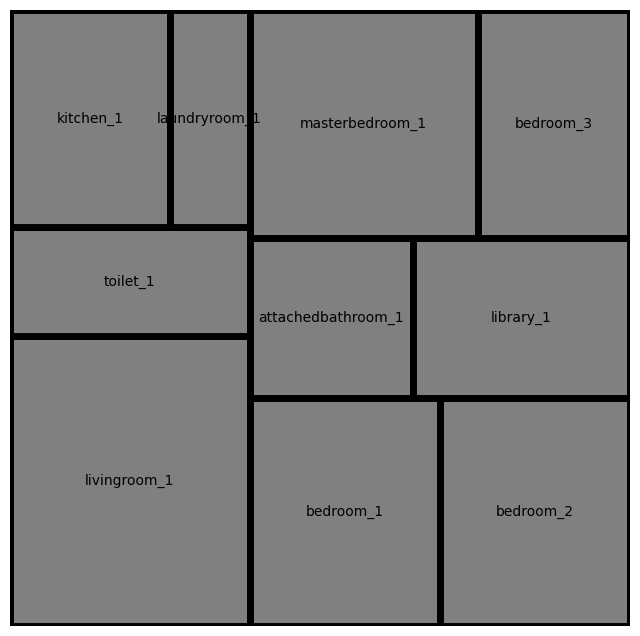

In [253]:
plot_treemap(room_data)

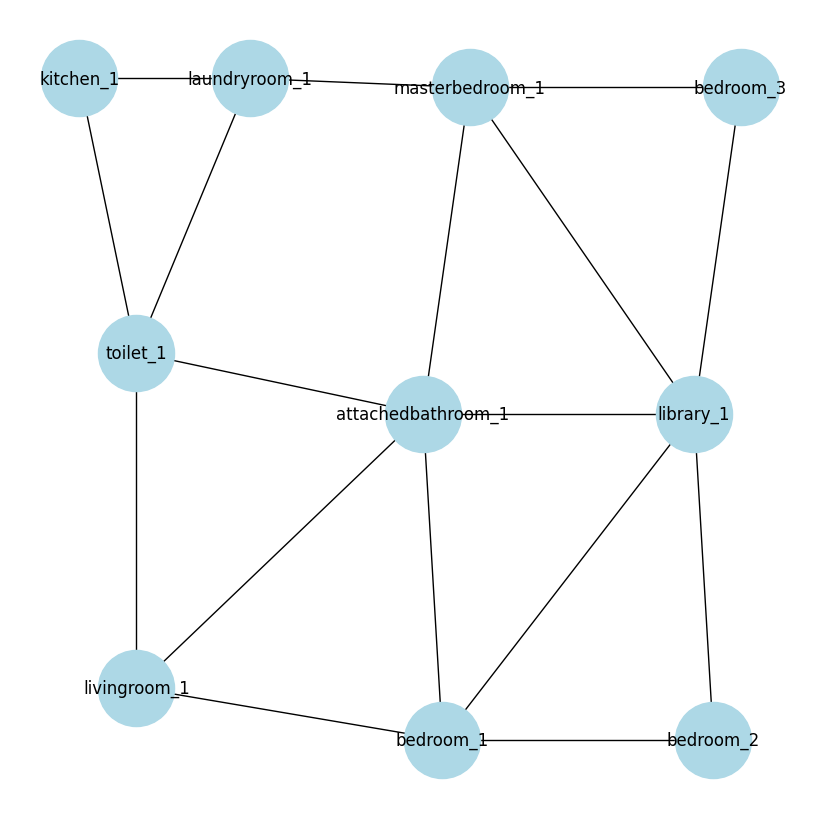

In [254]:
plot_graph(graph, room_data)

In [255]:
room_data_backbone = copy.deepcopy(room_data)
room_data_backbone

# Example usage
room_data_backbone = convert_to_absolute(room_data_backbone)

In [256]:
# Example Usage
graph_data = convert_to_graph_with_room_info(room_data_backbone)

graph_data['edges']

{((0, 0), (38.636364, 0)): ['livingroom_1'],
 ((38.636364, 0), (38.636364, 37.037037)): ['livingroom_1', 'bedroom_1'],
 ((38.636364, 37.037037), (38.636364, 47.058824)): ['livingroom_1',
  'attachedbathroom_1'],
 ((0, 47.058824), (38.636364, 47.058824)): ['livingroom_1', 'toilet_1'],
 ((0, 0), (0, 47.058824)): ['livingroom_1'],
 ((38.636364, 47.058824), (38.636364, 62.962963)): ['toilet_1',
  'attachedbathroom_1'],
 ((38.636364, 62.962963), (38.636364, 64.705882)): ['toilet_1',
  'masterbedroom_1'],
 ((0, 64.705882), (25.757576, 64.705882)): ['toilet_1', 'kitchen_1'],
 ((25.757576, 64.705882), (38.636364, 64.705882)): ['toilet_1',
  'laundryroom_1'],
 ((0, 47.058824), (0, 64.705882)): ['toilet_1'],
 ((25.757576, 64.705882), (25.757576, 100.0)): ['kitchen_1', 'laundryroom_1'],
 ((0, 100.0), (25.757576, 100.0)): ['kitchen_1'],
 ((0, 64.705882), (0, 100.0)): ['kitchen_1'],
 ((38.636364, 64.705882), (38.636364, 100.0)): ['laundryroom_1',
  'masterbedroom_1'],
 ((25.757576, 100.0), (38.6363

In [257]:
# Example Usage
updated_graph_data = remove_outside_edges_and_corners(graph_data)

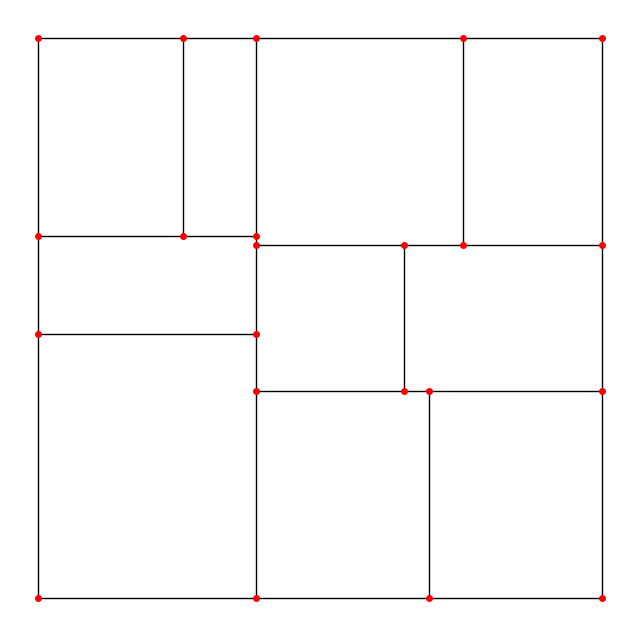

In [258]:
# Example Usage
plot_graph_new(graph_data)

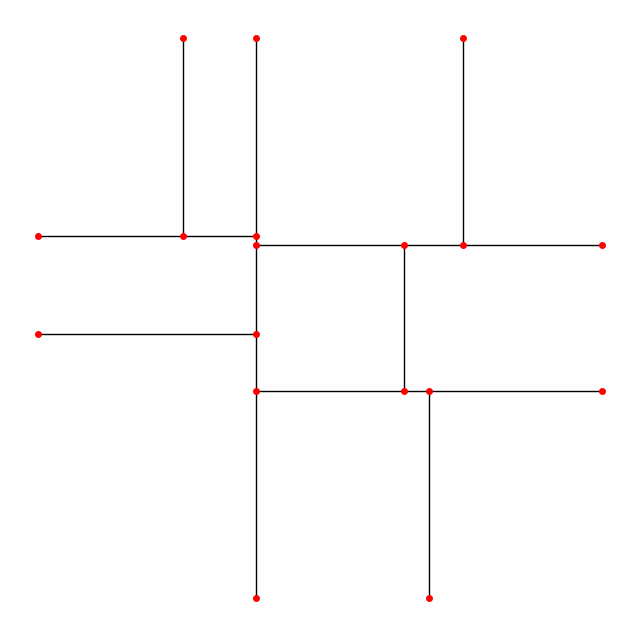

In [259]:
# Example Usage
plot_graph_new(updated_graph_data)

In [260]:
new_graph, connecting_vertices = remove_room(updated_graph_data, "livingroom_1")

removed edge: ['livingroom_1', 'bedroom_1']
removed edge: ['livingroom_1', 'toilet_1']
removed edge: ['livingroom_1', 'attachedbathroom_1']


In [261]:
connecting_vertices

[((38.636364, 37.037037), ['bedroom_1', 'attachedbathroom_1']),
 ((38.636364, 47.058824), ['livingroom_1', 'toilet_1'])]

In [262]:
new_graph

{'vertices': {(38.636364, 47.058824): ['livingroom_1', 'toilet_1'],
  (0, 64.705882): ['toilet_1', 'kitchen_1'],
  (38.636364, 64.705882): ['toilet_1', 'laundryroom_1'],
  (25.757576, 64.705882): ['kitchen_1', 'laundryroom_1'],
  (25.757576, 100.0): ['kitchen_1', 'laundryroom_1'],
  (38.636364, 100.0): ['laundryroom_1', 'masterbedroom_1'],
  (69.318182, 0): ['bedroom_1', 'bedroom_2'],
  (38.636364, 37.037037): ['bedroom_1', 'attachedbathroom_1'],
  (69.318182, 37.037037): ['bedroom_1', 'bedroom_2'],
  (100.0, 37.037037): ['bedroom_2', 'library_1'],
  (64.935065, 37.037037): ['attachedbathroom_1', 'library_1'],
  (38.636364, 62.962963): ['attachedbathroom_1', 'masterbedroom_1'],
  (64.935065, 62.962963): ['attachedbathroom_1', 'library_1'],
  (100.0, 62.962963): ['library_1', 'bedroom_3'],
  (75.454545, 62.962963): ['masterbedroom_1', 'bedroom_3'],
  (75.454545, 100.0): ['masterbedroom_1', 'bedroom_3']},
 'edges': {((38.636364, 47.058824), (38.636364, 62.962963)): ['toilet_1',
   'attac

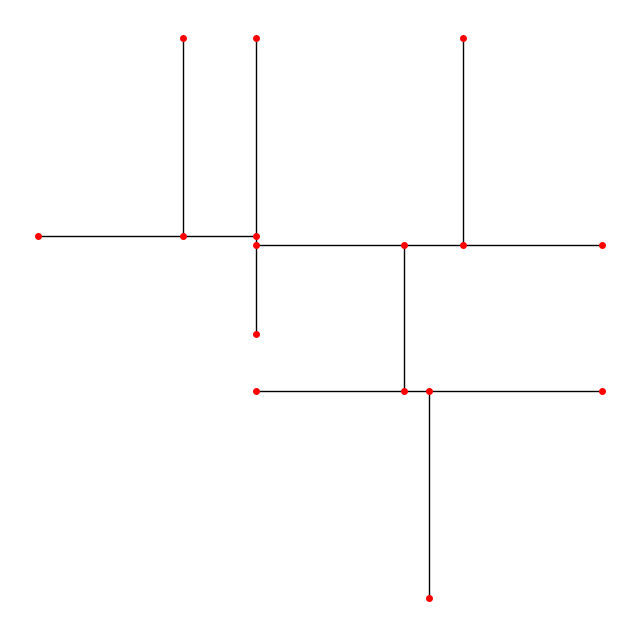

In [263]:
plot_graph_new(new_graph)

In [268]:
disconnected_rooms = ["laundryroom_1", "library_1", "masterbedroom_1", "bedroom_2", "bedroom_3", "kitchen_1"]

In [269]:
shortest_path_graph = shortest_path_to_connect_rooms(new_graph, connecting_vertices[1][0], disconnected_rooms)
print(shortest_path_graph)

[(((38.636364, 47.058824), (38.636364, 62.962963)), ['toilet_1', 'attachedbathroom_1']), (((38.636364, 62.962963), (38.636364, 64.705882)), ['toilet_1', 'masterbedroom_1']), (((25.757576, 64.705882), (38.636364, 64.705882)), ['toilet_1', 'laundryroom_1']), (((0, 64.705882), (25.757576, 64.705882)), ['toilet_1', 'kitchen_1']), (((0, 64.705882), (25.757576, 64.705882)), ['toilet_1', 'kitchen_1']), (((25.757576, 64.705882), (38.636364, 64.705882)), ['toilet_1', 'laundryroom_1']), (((38.636364, 62.962963), (38.636364, 64.705882)), ['toilet_1', 'masterbedroom_1']), (((38.636364, 62.962963), (64.935065, 62.962963)), ['attachedbathroom_1', 'masterbedroom_1']), (((64.935065, 62.962963), (75.454545, 62.962963)), ['library_1', 'masterbedroom_1']), (((75.454545, 62.962963), (100.0, 62.962963)), ['library_1', 'bedroom_3']), (((75.454545, 62.962963), (100.0, 62.962963)), ['library_1', 'bedroom_3']), (((64.935065, 62.962963), (75.454545, 62.962963)), ['library_1', 'masterbedroom_1']), (((64.935065, 

In [270]:
# Example usage:
cleaned_path = remove_redundant_edges(shortest_path_graph)
cleaned_path

[(((38.636364, 47.058824), (38.636364, 62.962963)),
  ['toilet_1', 'attachedbathroom_1']),
 (((38.636364, 62.962963), (38.636364, 64.705882)),
  ['toilet_1', 'masterbedroom_1']),
 (((25.757576, 64.705882), (38.636364, 64.705882)),
  ['toilet_1', 'laundryroom_1']),
 (((0, 64.705882), (25.757576, 64.705882)), ['toilet_1', 'kitchen_1']),
 (((38.636364, 62.962963), (64.935065, 62.962963)),
  ['attachedbathroom_1', 'masterbedroom_1']),
 (((64.935065, 62.962963), (75.454545, 62.962963)),
  ['library_1', 'masterbedroom_1']),
 (((75.454545, 62.962963), (100.0, 62.962963)), ['library_1', 'bedroom_3']),
 (((64.935065, 37.037037), (64.935065, 62.962963)),
  ['attachedbathroom_1', 'library_1']),
 (((64.935065, 37.037037), (69.318182, 37.037037)),
  ['bedroom_1', 'library_1']),
 (((69.318182, 37.037037), (100.0, 37.037037)), ['bedroom_2', 'library_1'])]

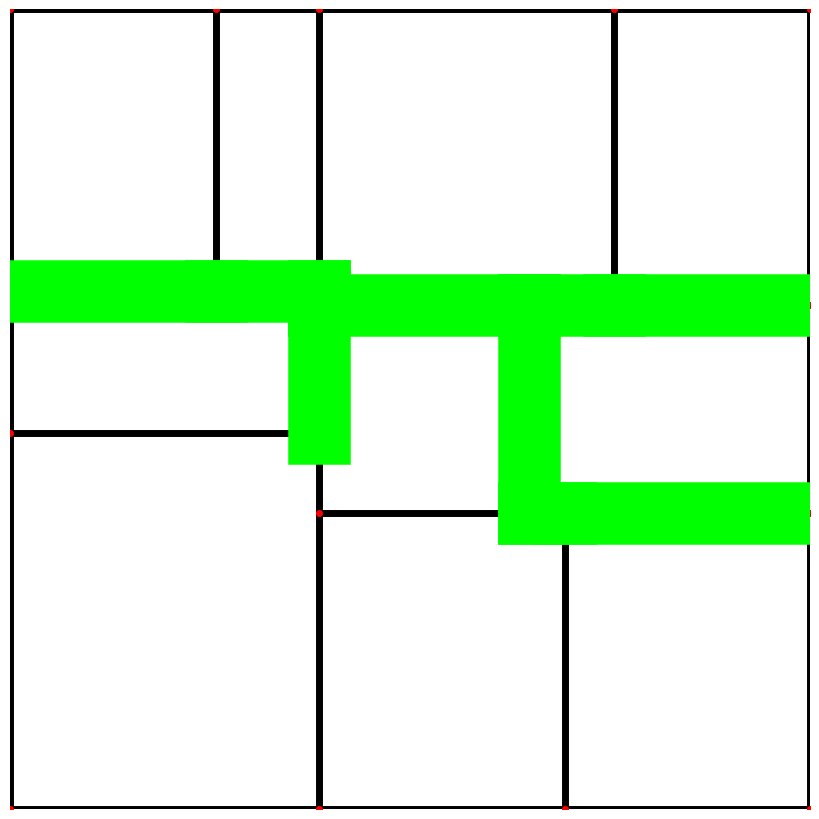

In [303]:
plot_graph_with_path(graph_data, cleaned_path, corridor_width=45, padding=0)

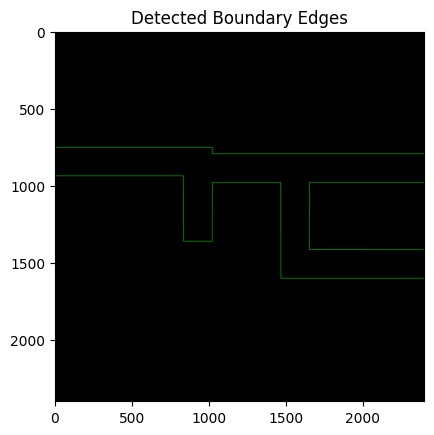

Detected Boundary Edges (as edges): [((0, 754), (0, 939)), ((0, 939), (832, 939)), ((832, 939), (834, 1363)), ((834, 1363), (1019, 1363)), ((1019, 1363), (1020, 981)), ((1020, 981), (1464, 981)), ((1464, 981), (1465, 1603)), ((1465, 1603), (2399, 1603)), ((2399, 1603), (2399, 1418)), ((2399, 1418), (1650, 1417)), ((1650, 1417), (1651, 981)), ((1651, 981), (2399, 981)), ((2399, 981), (2399, 796)), ((2399, 796), (1020, 796)), ((1020, 796), (1019, 754)), ((1019, 754), (0, 754))]


In [304]:
boundary_edges = get_color_boundary_edges(image_path="corridor.png")

In [305]:
normalized_edges = resize_graph_edges(original_graph_edges=boundary_edges, original_size=2400, new_size=100)

Normalized Boundary Edges (100x100 scale):


In [306]:
merged_normalized_edges = merge_close_values_in_graph(normalized_edges)

merged_normalized_edges

[((-0.1, 68.58333333333333), (-0.1, 60.875)),
 ((-0.1, 60.875), (34.66666666666667, 60.875)),
 ((34.66666666666667, 60.875), (34.66666666666667, 43.208333333333336)),
 ((34.66666666666667, 43.208333333333336),
  (42.45833333333333, 43.208333333333336)),
 ((42.45833333333333, 43.208333333333336),
  (42.45833333333333, 59.12500000000001)),
 ((42.45833333333333, 59.12500000000001), (61.0, 59.12500000000001)),
 ((61.0, 59.12500000000001), (61.0, 33.20833333333333)),
 ((61.0, 33.20833333333333), (99.95833333333334, 33.20833333333333)),
 ((99.95833333333334, 33.20833333333333),
  (99.95833333333334, 40.91666666666667)),
 ((99.95833333333334, 40.91666666666667), (68.75, 40.91666666666667)),
 ((68.75, 40.91666666666667), (68.75, 59.12500000000001)),
 ((68.75, 59.12500000000001), (99.95833333333334, 59.12500000000001)),
 ((99.95833333333334, 59.12500000000001),
  (99.95833333333334, 66.83333333333333)),
 ((99.95833333333334, 66.83333333333333),
  (42.45833333333333, 66.83333333333333)),
 ((42.4

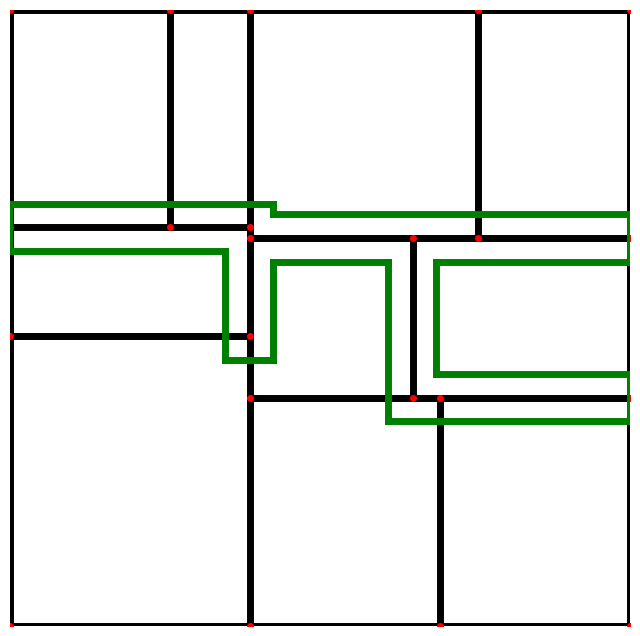

In [307]:
plot_graph_and_contour(graph_data, merged_normalized_edges, padding=0)

In [308]:
# Convert corridor edges
corridor_edges_dict = format_corridor_edges(merged_normalized_edges)

In [309]:
# Merge corridor edges into graph data
merged_edges = {**graph_data['edges'], **corridor_edges_dict}

In [310]:
split_edges_new = split_edges_at_intersections(merged_edges)
split_edges_new

{((0, 0), (38.636364, 0)): ['livingroom_1'],
 ((38.636364, 0), (38.636364, 37.037037)): ['livingroom_1', 'bedroom_1'],
 ((38.636364, 37.037037), (38.636364, 43.208333333333336)): ['livingroom_1',
  'attachedbathroom_1'],
 ((38.636364, 43.208333333333336), (38.636364, 47.058824)): ['livingroom_1',
  'attachedbathroom_1'],
 ((0, 47.058824), (34.66666666666667, 47.058824)): ['livingroom_1',
  'toilet_1'],
 ((34.66666666666667, 47.058824), (38.636364, 47.058824)): ['livingroom_1',
  'toilet_1'],
 ((0, 0), (0, 47.058824)): ['livingroom_1'],
 ((38.636364, 47.058824), (38.636364, 62.962963)): ['toilet_1',
  'attachedbathroom_1'],
 ((38.636364, 62.962963), (38.636364, 64.705882)): ['toilet_1',
  'masterbedroom_1'],
 ((0, 64.705882), (25.757576, 64.705882)): ['toilet_1', 'kitchen_1'],
 ((25.757576, 64.705882), (38.636364, 64.705882)): ['toilet_1',
  'laundryroom_1'],
 ((0, 47.058824), (0.0, 60.875)): ['toilet_1'],
 ((0.0, 60.875), (0, 64.705882)): ['toilet_1'],
 ((25.757576, 64.705882), (25.757

In [311]:
unique_edges = remove_duplicate_edges(split_edges_new)

In [312]:
# Get room edges within the corridor
room_edges_in_corridor, corridor_polygon = get_room_edges_within_corridor(merged_normalized_edges, unique_edges)

In [313]:
room_edges_in_corridor

{'livingroom_1': [((38.636364, 43.208333333333336), (38.636364, 47.058824)),
  ((34.66666666666667, 47.058824), (38.636364, 47.058824))],
 'attachedbathroom_1': [((38.636364, 43.208333333333336),
   (38.636364, 47.058824)),
  ((38.636364, 47.058824), (38.636364, 62.962963)),
  ((61.0, 37.037037), (64.935065, 37.037037)),
  ((64.935065, 37.037037), (64.935065, 62.962963)),
  ((38.636364, 62.962963), (64.935065, 62.962963))],
 'toilet_1': [((34.66666666666667, 47.058824), (38.636364, 47.058824)),
  ((38.636364, 47.058824), (38.636364, 62.962963)),
  ((38.636364, 62.962963), (38.636364, 64.705882)),
  ((0, 64.705882), (25.757576, 64.705882)),
  ((25.757576, 64.705882), (38.636364, 64.705882)),
  ((0.0, 60.875), (0, 64.705882))],
 'masterbedroom_1': [((38.636364, 62.962963), (38.636364, 64.705882)),
  ((38.636364, 64.705882), (38.636364, 68.58333333333333)),
  ((38.636364, 62.962963), (64.935065, 62.962963)),
  ((64.935065, 62.962963), (75.454545, 62.962963)),
  ((75.454545, 62.962963), (7

In [314]:
corridor_edges, room_edges = get_room_and_corridor_edges(unique_edges)

In [315]:
corridor_edges_in_rooms = get_corridor_edges_within_rooms(room_edges, corridor_edges)

In [316]:
corridor_edges_in_rooms

{'toilet_1': [((0.0, 60.875), (34.66666666666667, 60.875)),
  ((34.66666666666667, 47.058824), (34.66666666666667, 60.875))],
 'livingroom_1': [((34.66666666666667, 43.208333333333336),
   (34.66666666666667, 47.058824)),
  ((34.66666666666667, 43.208333333333336), (38.636364, 43.208333333333336))],
 'attachedbathroom_1': [((38.636364, 43.208333333333336),
   (42.45833333333333, 43.208333333333336)),
  ((42.45833333333333, 43.208333333333336),
   (42.45833333333333, 59.12500000000001)),
  ((42.45833333333333, 59.12500000000001), (61.0, 59.12500000000001)),
  ((61.0, 37.037037), (61.0, 59.12500000000001))],
 'bedroom_1': [((61.0, 33.20833333333333), (61.0, 37.037037)),
  ((61.0, 33.20833333333333), (69.318182, 33.20833333333333))],
 'bedroom_2': [((69.318182, 33.20833333333333),
   (99.95833333333334, 33.20833333333333)),
  ((99.95833333333334, 33.20833333333333), (99.95833333333334, 37.037037))],
 'library_1': [((99.95833333333334, 37.037037),
   (99.95833333333334, 40.91666666666667))

In [317]:
def remove_given_edges(graph_edges, edges_to_remove):
    """Removes given edges from a given dictionary of edges."""
    
    # Collect all edges from edges_to_remove into a set
    edges_set = set()
    for edges in edges_to_remove.values():
        edges_set.update(edges)

    # Remove edges from unique_edges if they exist in corridor_edges
    filtered_edges = {edge: labels for edge, labels in graph_edges.items() if edge not in edges_set}

    return filtered_edges

def remove_corridor_edges_from_living_room(graph_edges, edges_to_remove):
    """Removes given edges from a given dictionary of edges."""
    
    # Collect all edges from edges_to_remove into a set
    edges_set = []
    for key, value in edges_to_remove.items():
        if key == "livingroom_1":
           for edge in value:
            edges_set.append(edge)
           print(len(edges_set))

    filtered_edges = {edge: labels for edge, labels in graph_edges.items() if edge not in edges_set}

    return filtered_edges


In [318]:
updated_edges = remove_given_edges(unique_edges, room_edges_in_corridor)
len(updated_edges.keys())

50

In [319]:
len(unique_edges.keys())

69

In [320]:
unique_edges

{((0, 0), (38.636364, 0)): ['livingroom_1'],
 ((38.636364, 0), (38.636364, 37.037037)): ['livingroom_1', 'bedroom_1'],
 ((38.636364, 37.037037), (38.636364, 43.208333333333336)): ['livingroom_1',
  'attachedbathroom_1'],
 ((38.636364, 43.208333333333336), (38.636364, 47.058824)): ['livingroom_1',
  'attachedbathroom_1'],
 ((0, 47.058824), (34.66666666666667, 47.058824)): ['livingroom_1',
  'toilet_1'],
 ((34.66666666666667, 47.058824), (38.636364, 47.058824)): ['livingroom_1',
  'toilet_1'],
 ((0, 0), (0, 47.058824)): ['livingroom_1'],
 ((38.636364, 47.058824), (38.636364, 62.962963)): ['toilet_1',
  'attachedbathroom_1'],
 ((38.636364, 62.962963), (38.636364, 64.705882)): ['toilet_1',
  'masterbedroom_1'],
 ((0, 64.705882), (25.757576, 64.705882)): ['toilet_1', 'kitchen_1'],
 ((25.757576, 64.705882), (38.636364, 64.705882)): ['toilet_1',
  'laundryroom_1'],
 ((0, 47.058824), (0.0, 60.875)): ['toilet_1'],
 ((0.0, 60.875), (0, 64.705882)): ['toilet_1'],
 ((25.757576, 64.705882), (25.757

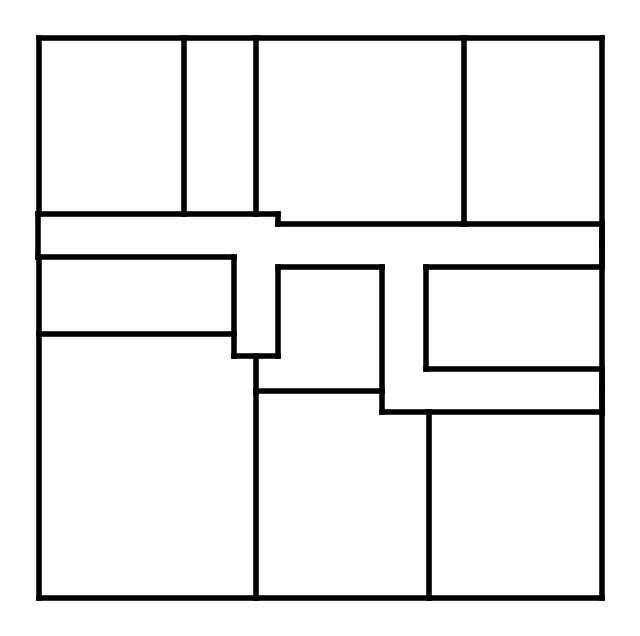

In [321]:
plot_graph_edges(updated_edges)

In [322]:
updated_edges_removed_corridor_from_living_room = remove_corridor_edges_from_living_room(updated_edges, corridor_edges_in_rooms)

2


In [323]:
updated_edges_removed_corridor_from_living_room

{((0, 0), (38.636364, 0)): ['livingroom_1'],
 ((38.636364, 0), (38.636364, 37.037037)): ['livingroom_1', 'bedroom_1'],
 ((38.636364, 37.037037), (38.636364, 43.208333333333336)): ['livingroom_1',
  'attachedbathroom_1'],
 ((0, 47.058824), (34.66666666666667, 47.058824)): ['livingroom_1',
  'toilet_1'],
 ((0, 0), (0, 47.058824)): ['livingroom_1'],
 ((0, 47.058824), (0.0, 60.875)): ['toilet_1'],
 ((25.757576, 68.58333333333333), (25.757576, 100.0)): ['kitchen_1',
  'laundryroom_1'],
 ((0, 100.0), (25.757576, 100.0)): ['kitchen_1'],
 ((0.0, 68.58333333333333), (0, 100.0)): ['kitchen_1'],
 ((38.636364, 68.58333333333333), (38.636364, 100.0)): ['laundryroom_1',
  'masterbedroom_1'],
 ((25.757576, 100.0), (38.636364, 100.0)): ['laundryroom_1'],
 ((38.636364, 0), (69.318182, 0)): ['bedroom_1'],
 ((69.318182, 0), (69.318182, 33.20833333333333)): ['bedroom_1', 'bedroom_2'],
 ((38.636364, 37.037037), (61.0, 37.037037)): ['bedroom_1',
  'attachedbathroom_1'],
 ((69.318182, 0), (100.0, 0)): ['bedr

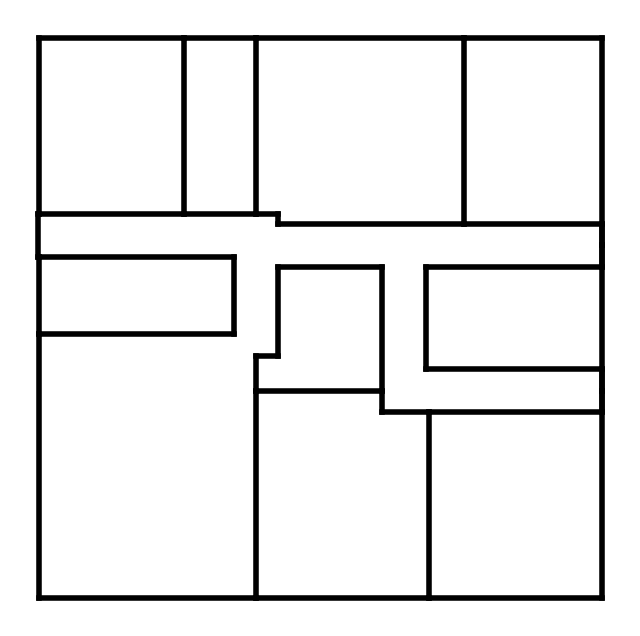

In [324]:
plot_graph_edges(updated_edges_removed_corridor_from_living_room)

In [325]:
corridor_edges_in_rooms

updated_corridor_edges_in_rooms = {}
# removing corridor edges enclosed in the living room.
for key, value in corridor_edges_in_rooms.items():
    if key != 'livingroom_1':
        updated_corridor_edges_in_rooms[key] = value

room_edges_with_corridor_connection = copy.deepcopy(updated_edges_removed_corridor_from_living_room)

for key, value in updated_corridor_edges_in_rooms.items():
    for edge in value:
        label = [key, 'corridor']
        room_edges_with_corridor_connection[edge] = label

In [326]:
room_edges_with_corridor_connection

{((0, 0), (38.636364, 0)): ['livingroom_1'],
 ((38.636364, 0), (38.636364, 37.037037)): ['livingroom_1', 'bedroom_1'],
 ((38.636364, 37.037037), (38.636364, 43.208333333333336)): ['livingroom_1',
  'attachedbathroom_1'],
 ((0, 47.058824), (34.66666666666667, 47.058824)): ['livingroom_1',
  'toilet_1'],
 ((0, 0), (0, 47.058824)): ['livingroom_1'],
 ((0, 47.058824), (0.0, 60.875)): ['toilet_1'],
 ((25.757576, 68.58333333333333), (25.757576, 100.0)): ['kitchen_1',
  'laundryroom_1'],
 ((0, 100.0), (25.757576, 100.0)): ['kitchen_1'],
 ((0.0, 68.58333333333333), (0, 100.0)): ['kitchen_1'],
 ((38.636364, 68.58333333333333), (38.636364, 100.0)): ['laundryroom_1',
  'masterbedroom_1'],
 ((25.757576, 100.0), (38.636364, 100.0)): ['laundryroom_1'],
 ((38.636364, 0), (69.318182, 0)): ['bedroom_1'],
 ((69.318182, 0), (69.318182, 33.20833333333333)): ['bedroom_1', 'bedroom_2'],
 ((38.636364, 37.037037), (61.0, 37.037037)): ['bedroom_1',
  'attachedbathroom_1'],
 ((69.318182, 0), (100.0, 0)): ['bedr

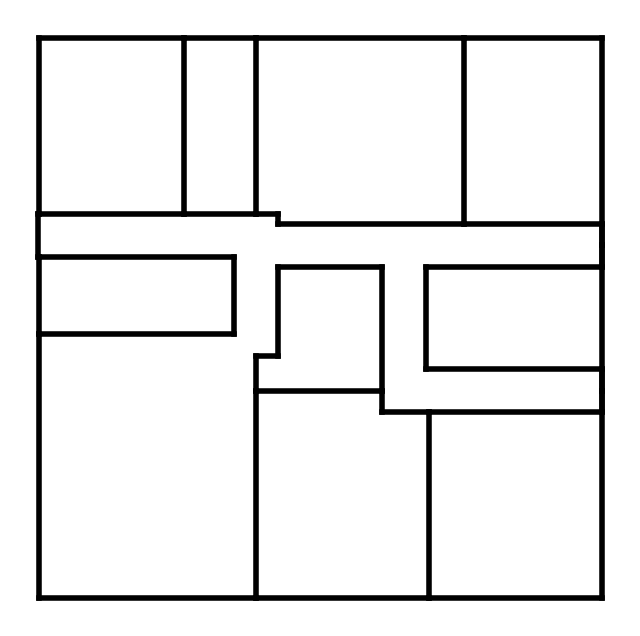

In [327]:
plot_graph_edges(room_edges_with_corridor_connection)

In [331]:
import random

def generate_door_edges(edges_dict, door_size=4, offset_threshold=1):
    door_edges = {}
    added_doors = set()  # Track label combinations with doors

    for (start, end), labels in edges_dict.items():
        if len(labels) > 1:  # Only process shared edges
            label_key = frozenset(labels)  # Order-independent tracking

            if label_key in added_doors:
                continue  # Skip if a door has already been added for this label pair

            x1, y1 = start
            x2, y2 = end
            
            # Determine if the edge is horizontal or vertical
            if x1 == x2:  # Vertical edge
                edge_length = abs(y2 - y1)
                if edge_length > door_size + offset_threshold * 2:
                    min_door_start = y1 + offset_threshold
                    max_door_start = y2 - door_size - offset_threshold
                    door_start = random.uniform(min_door_start, max_door_start)
                    
                    door_end = door_start + door_size
                    door_edges[((x1, door_start), (x2, door_end))] = labels
                    added_doors.add(label_key)

            elif y1 == y2:  # Horizontal edge
                edge_length = abs(x2 - x1)
                if edge_length > door_size + offset_threshold * 2:
                    min_door_start = x1 + offset_threshold
                    max_door_start = x2 - door_size - offset_threshold
                    door_start = random.uniform(min_door_start, max_door_start)
                    
                    door_end = door_start + door_size
                    door_edges[((door_start, y1), (door_end, y2))] = labels
                    added_doors.add(label_key)

    return door_edges


In [332]:
door_edges = generate_door_edges(room_edges_with_corridor_connection)
door_edges

{((38.636364, 3.519313776673093),
  (38.636364, 7.519313776673092)): ['livingroom_1', 'bedroom_1'],
 ((38.636364, 38.13172667232038),
  (38.636364, 42.13172667232038)): ['livingroom_1', 'attachedbathroom_1'],
 ((2.1317919879764387, 47.058824),
  (6.131791987976438, 47.058824)): ['livingroom_1', 'toilet_1'],
 ((25.757576, 70.24125160934607),
  (25.757576, 74.24125160934607)): ['kitchen_1', 'laundryroom_1'],
 ((38.636364, 89.48916433967194),
  (38.636364, 93.48916433967194)): ['laundryroom_1', 'masterbedroom_1'],
 ((69.318182, 2.7910584657712163),
  (69.318182, 6.791058465771217)): ['bedroom_1', 'bedroom_2'],
 ((53.28976211663546, 37.037037),
  (57.28976211663546, 37.037037)): ['bedroom_1', 'attachedbathroom_1'],
 ((75.454545, 75.81710846849705),
  (75.454545, 79.81710846849705)): ['masterbedroom_1', 'bedroom_3'],
 ((10.19884864180309, 60.875), (14.19884864180309, 60.875)): ['toilet_1',
  'corridor'],
 ((42.45833333333333, 49.08642081733571),
  (42.45833333333333, 53.08642081733571)): ['

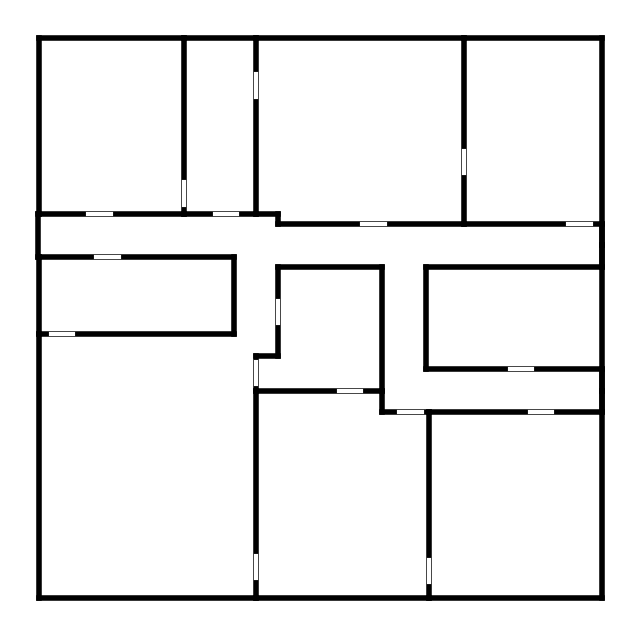

In [333]:
plot_graph_edges_with_doors(room_edges_with_corridor_connection, door_edges)